# Directional change indicator

### Import

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path 
import datatable as dt

from matplotlib import pyplot as plt
from collections import defaultdict

In [6]:
filepath = Path('../../data/csv/crypto_market_data.csv')

### Get data

In [7]:
df = dt.fread(filepath).to_pandas() 
df = df.T.set_index([0, 1]).T
df = df.set_index('')
df = df.astype(float)
df.index.names = ['date']
df.head(3)

0                          USDT-USD                                \
1                             Close      High       Low      Open   
date                                                                
2020-04-07 09:00:00+00:00  1.000498  1.002541  1.000122  1.001162   
2020-04-07 10:00:00+00:00  1.001372  1.003510  0.999029  1.000605   
2020-04-07 11:00:00+00:00  1.001356  1.003241  0.999101  1.001339   

0                                           BTC-USD                            \
1                               Volume        Close         High          Low   
date                                                                            
2020-04-07 09:00:00+00:00          0.0  7376.598145  7376.598145  7340.555176   
2020-04-07 10:00:00+00:00  574005248.0  7420.056152  7427.939453  7360.825684   
2020-04-07 11:00:00+00:00   35094528.0  7370.503418  7419.238770  7370.503418   

0                                                    ...   ADA-USD            \
1                                 Open       Volume  ...     Close      High   
date                                                 ...                       
2020-04-07 09:00:00+00:00  7354.051270          0.0  ...  0.036377  0.036377   
2020-04-07 10:00:00+00:00  7377.067871  268472320.0  ...  0.036766  0.036869   
2020-04-07 11:00:00+00:00  7419.238770          0.0  ...  0.036246  0.036799   

0                                                         BNT-USD            \
1                               Low      Open    Volume     Close      High   
date                                                                          
2020-04-07 09:00:00+00:00  0.036196  0.036260       0.0  0.198263  0.198263   
2020-04-07 10:00:00+00:00  0.036326  0.036408  113320.0  0.199927  0.200089   
2020-04-07 11:00:00+00:00  0.036246  0.036799       0.0  0.197452  0.199911   

0                                                       
1                               Low      Open   Volume  
date                                                    
2020-04-07 09:00:00+00:00  0.197084  0.197758      0.0  
2020-04-07 10:00:00+00:00  0.198244  0.198244  64615.0  
2020-04-07 11:00:00+00:00  0.197452  0.199911      0.0  

[3 rows x 50 columns]

In [12]:
df_btc = df['BTC-USD']['Close']
display(df_btc.head(3))

date
2020-04-07 09:00:00+00:00    7376.598145
2020-04-07 10:00:00+00:00    7420.056152
2020-04-07 11:00:00+00:00    7370.503418
Name: Close, dtype: float64

## Class DC_transform

Goal : have everything inside a well designed class
- load the data in the __init__() method
- define a method transform() that returns a new dataframe with the detected events
    - need more work for the moment --> I wanna be sure that my detected events are ok
- define a method hmm() that learns how to detect regimes based on the Time Adjusted Return (as defined in the reference book)

In [61]:
df_btc = df_btc.head(1000)

In [68]:
init_date, init_price = df_btc.index[0], df_btc.values[0]

In [69]:
alpha = 0.1

In [91]:
state_market = {
    'ext_price': init_price,
    'ext_date': init_date
}

state_event = { 
    'event':['down'],
    'price_event':[init_price],
    'date_event':[init_date]
}

for (date, price) in df_btc.items():
    if state_event['event'][-1] == 'up':
        if price > state_market['ext_price']:
            state_market['ext_price'] = price
            state_market['ext_date'] = date
        
        r = (price - state_market['ext_price'])/state_market['ext_price']
        if r < alpha:
            state_event['event'].append('down')
            state_event['price_event'].append(state_market['ext_price'])
            state_event['date_event'].append(state_market['ext_date'])
            
            state_market['ext_price'] = price
            state_market['ext_date'] = date
            
            #print(date, price)
            print({'event':'down','price_event':state_market['ext_price'],'date_event':state_market['ext_date']})
            
    else:
        if price < state_market['ext_price']:
            state_market['ext_price'] = price
            state_market['ext_date'] = date
        
        r = (price - state_market['ext_price'])/state_market['ext_price']
        if r > alpha:
            state_event['event'].append('up')
            state_event['price_event'].append(state_market['ext_price'])
            state_event['date_event'].append(state_market['ext_date'])
            
            state_market['ext_price'] = price
            state_market['ext_date'] = date
            
            #print(date, price)
            print({'event':'up','price_event':state_market['ext_price'],'date_event':state_market['ext_date']})

{'event': 'up', 'price_event': 7260.4013671875, 'date_event': '2020-04-18 22:00:00+00:00'}
{'event': 'down', 'price_event': 7270.87158203125, 'date_event': '2020-04-19 00:00:00+00:00'}
{'event': 'up', 'price_event': 7522.20458984375, 'date_event': '2020-04-24 00:00:00+00:00'}
{'event': 'down', 'price_event': 7519.31982421875, 'date_event': '2020-04-24 01:00:00+00:00'}
{'event': 'up', 'price_event': 8326.83203125, 'date_event': '2020-04-29 13:00:00+00:00'}
{'event': 'down', 'price_event': 8368.9345703125, 'date_event': '2020-04-29 14:00:00+00:00'}
{'event': 'up', 'price_event': 9370.3642578125, 'date_event': '2020-04-30 05:00:00+00:00'}
{'event': 'down', 'price_event': 9318.2685546875, 'date_event': '2020-04-30 06:00:00+00:00'}
{'event': 'up', 'price_event': 9540.9697265625, 'date_event': '2020-05-07 16:00:00+00:00'}
{'event': 'down', 'price_event': 9797.6591796875, 'date_event': '2020-05-07 17:00:00+00:00'}
{'event': 'up', 'price_event': 9290.416015625, 'date_event': '2020-05-13 21:00:

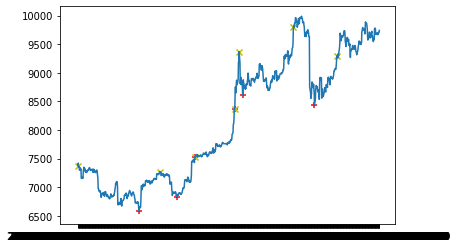

In [92]:
up_trend = np.array(state_event['event']) == 'up'
down_trend = np.array(state_event['event']) == 'down'

up_price = np.array(state_event['price_event'])[up_trend]
down_price = np.array(state_event['price_event'])[down_trend]

up_date = np.array(state_event['date_event'])[up_trend]
down_date = np.array(state_event['date_event'])[down_trend]

plt.plot(df_btc.index, df_btc.values)
plt.scatter(up_date, up_price, c='r', marker='+')
plt.scatter(down_date, down_price, c='y', marker='x')

### Save features

In [10]:
filepath = Path('../csv/features_btc_ta.csv')

In [11]:
#df_btc_ta.to_csv(filepath)